In [16]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

DATA_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/PhdProjects/Complicor/Data/"

In [3]:
MBII_z4_filename = "bhprops_034.txt"
MBII_z4 = np.loadtxt(DATA_DIRECTORY + MBII_z4_filename)

408.5


Text(0.7, 0.85, 'Bin size = 8.73 $h^{-1}$kpc')

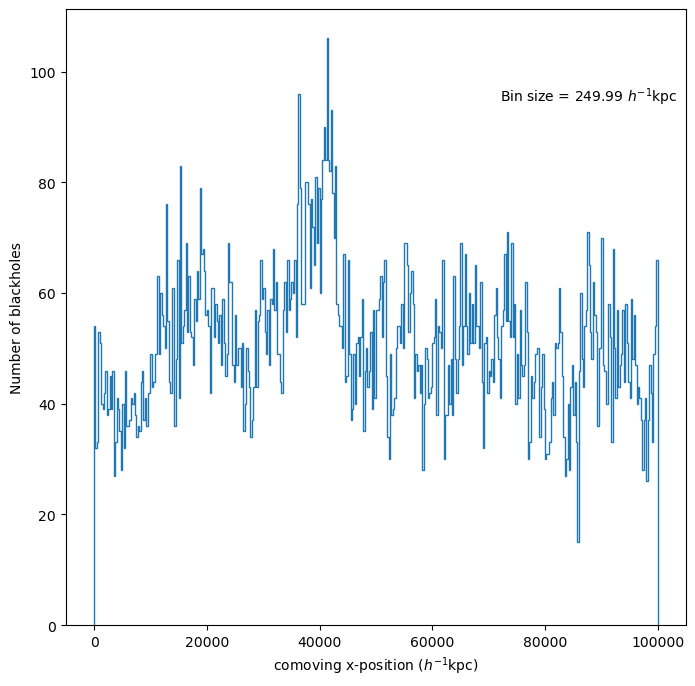

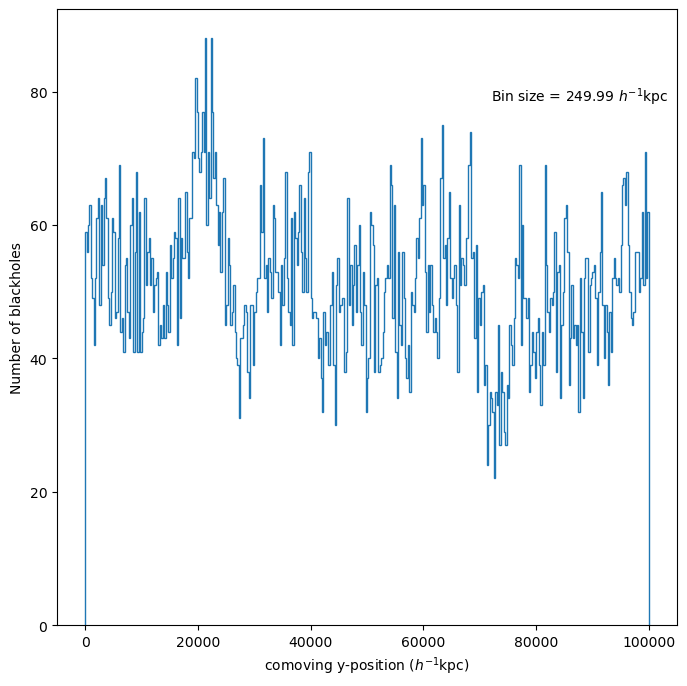

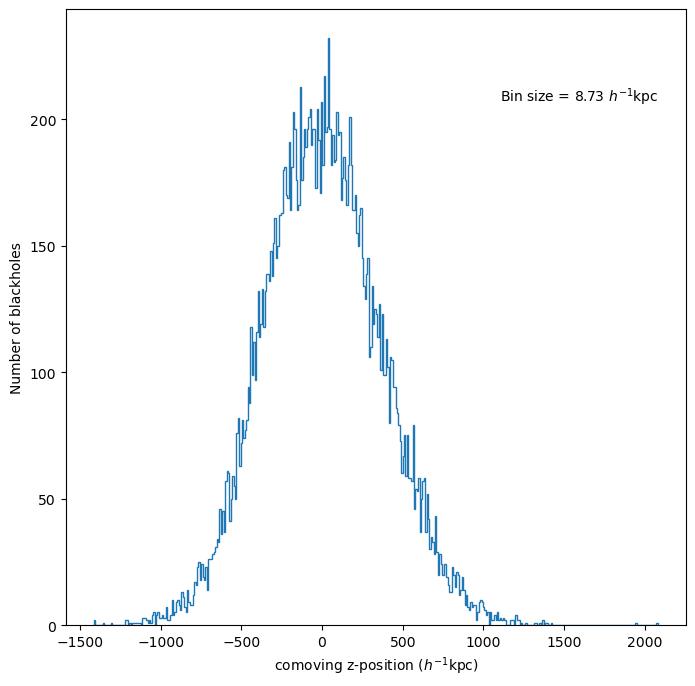

In [4]:
bh_pos_x = np.copy(MBII_z4[:, 2])
bh_pos_y = np.copy(MBII_z4[:, 3])
bh_pos_z = np.copy(MBII_z4[:, 4])
print(len(bh_pos_x)/50)

n_bins = 400
fig, ax = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_x, bins=n_bins, histtype='step')[0];
ax.set_xlabel(r'comoving x-position ($h^{-1}$kpc)')
ax.set_ylabel(r'Number of blackholes')
ax.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_x) - np.min(bh_pos_x))/n_bins, 2)), transform = ax.transAxes)

fig2, ax2 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_y, bins=n_bins, histtype='step')[0];
ax2.set_xlabel(r'comoving y-position ($h^{-1}$kpc)')
ax2.set_ylabel(r'Number of blackholes')
ax2.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_y) - np.min(bh_pos_y))/n_bins, 2)), transform = ax2.transAxes)

fig3, ax3 = plt.subplots(figsize = (8,8))
hist_data = plt.hist(bh_pos_z, bins=n_bins, histtype='step')[0];
ax3.set_xlabel(r'comoving z-position ($h^{-1}$kpc)')
ax3.set_ylabel(r'Number of blackholes')
ax3.text(0.70, 0.85, r'Bin size = {} $h^{{-1}}$kpc'.format(np.round((np.max(bh_pos_z) - np.min(bh_pos_z))/n_bins, 2)), transform = ax3.transAxes)

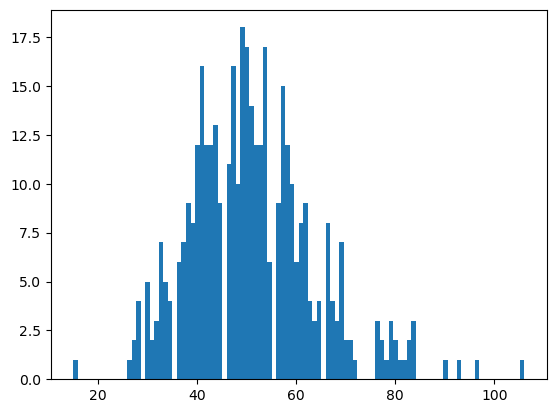

In [54]:
plt.hist(hist_data, bins=100);

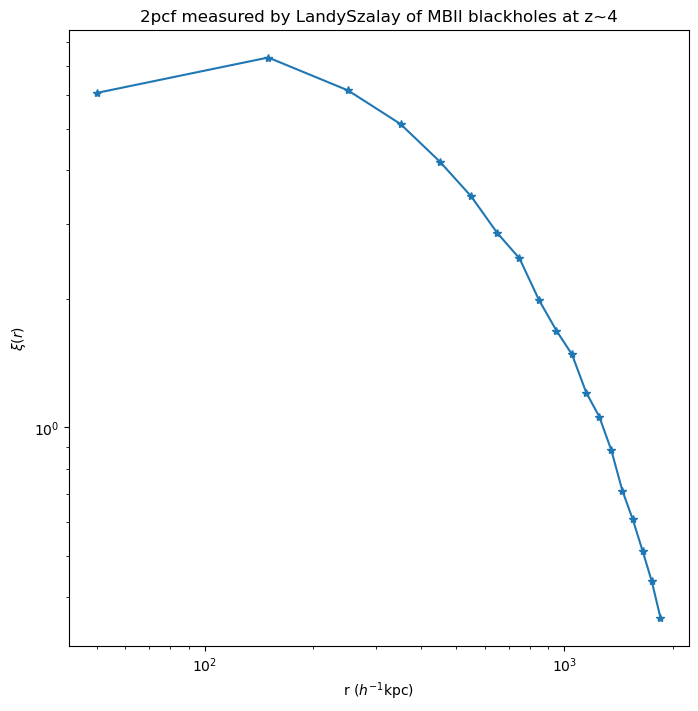

In [85]:
mult = 5
n_D = len(bh_pos_x)
n_rand = mult * n_D
rand_x = np.random.uniform(np.min(bh_pos_x), np.max(bh_pos_x), n_rand)
rand_y = np.random.uniform(np.min(bh_pos_y), np.max(bh_pos_y), n_rand)
rand_z = np.random.uniform(np.min(bh_pos_z), np.max(bh_pos_z), n_rand)

bins = np.arange(0, 2000, 100)
bin_mids = (bins[0:-1] + bins[1:])/2

result_DD = DD(autocorr=1, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, periodic=False)
result_RR = DD(autocorr=1, nthreads=1, binfile=bins, X1 = rand_x, Y1 = rand_y, Z1 = rand_z, periodic=False)
result_DR = DD(autocorr=0, nthreads=1, binfile=bins, X1 = bh_pos_x, Y1 = bh_pos_y, Z1 = bh_pos_z, X2 = rand_x, Y2 = rand_y, Z2 = rand_z, periodic=False)

DD_norm = (n_D * (n_D - 1))/2
RR_norm = (n_rand * (n_rand - 1))/2
DR_norm = n_D * n_rand

DD_count = result_DD['npairs']/2
RR_count = result_RR['npairs']/2
DR_count = result_DR['npairs']

LandSzal2pcf = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/(RR_count/RR_norm)

fig, ax = plt.subplots(figsize = (8,8))
ax.plot(bin_mids, LandSzal2pcf, '-*')
ax.set_xlabel(r'r ($h^{-1}$kpc)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("2pcf measured by LandySzalay of MBII blackholes at z~4")
ax.set_xscale('log')
ax.set_yscale('log')

In [21]:
# fig, ax = plt.subplots(figsize = (8,8))

pos_z = np.arange(np.min(bh_pos_z), np.max(bh_pos_z), 5)[:,np.newaxis]
kde = KernelDensity(kernel="gaussian", bandwidth=50).fit(bh_pos_z[:,np.newaxis])
log_dens = kde.score_samples(pos_z)
pdf = np.exp(log_dens)
# ax.fill(pos_z[:, 0], pdf, fc="#AAAAFF")
cdf = np.cumsum(pdf)
cdf = cdf / np.max(cdf)
cdf = np.insert(cdf, 0, 0)

uni_val = np.random.rand(n_rand)
bin_indices = np.searchsorted(cdf, uni_val)
bin_edges = pos_z[bin_indices - 1]

In [ ]:
cdf = cdf / np.max(cdf)

# plot data and pdf  
plt.hist(X, 25, density=True, histtype='stepfilled', alpha=0.3)
plt.plot(x, pdf, '-k')

# plot cdf, scaled to the y limits of the above plot
xmin, xmax, ymin, ymax = plt.axis()
plt.plot(x, cdf * ymax, '-b');

In [ ]:
def make_rand_from_dist_any(red_col, bins, n_samples):            #Make a random z distribution from the data z distribution
    hist, edges = np.histogram(red_col, bins=bins)
    bin_widths = np.diff(edges)
    cdf = np.cumsum(hist * bin_widths) / np.sum(hist * bin_widths)
    cdf = np.insert(cdf, 0, 0)
    #plt.stairs(cdf, bins)

    # Generate new z values that follow the histogram distribution
    uniform_values = np.random.rand(n_samples)
    bin_indices = np.searchsorted(cdf, uniform_values)
    bin_edges = edges[bin_indices-1]
    bin_diff = edges[bin_indices] - edges[bin_indices-1]
    bin_weights = (uniform_values - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])

    new_z_values = bin_edges + bin_weights * bin_diff

    ##---------------------------------------------
    ## Making changes to see how clustering changes
    #new_z_values = np.random.uniform(2.9, 3.5, n_samples)
    #new_z_values[300:] = new_z_values[300:] * 1.01
    ##

    return new_z_values

In [7]:
bh_pos_z[:,np.newaxis]

array([[  86.23714],
       [-103.1571 ],
       [ -49.71245],
       ...,
       [ 270.8329 ],
       [-181.5829 ],
       [-737.1361 ]])